# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Dense, Activation, LSTM, Conv1D, GlobalAveragePooling1D, BatchNormalization, Dropout

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

2023-12-06 21:03:07.471367: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 21:03:07.471387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 21:03:07.477567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 21:03:08.334834: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Getting The Data

In [2]:
review_data = pd.read_json('Cell_Phones_and_Accessories_5.json', lines = True)
review_data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


## EDA

In [3]:
review_data.isnull().sum()

reviewerID           0
asin                 0
reviewerName      3519
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

Dropping reviewerName as it has null values and it is not important to data

In [4]:
review_data = review_data.drop(['reviewerName'], axis =1)
review_data.head()

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [5]:
review_data['overall'].value_counts()

overall
5    108664
4     39993
3     21439
1     13279
2     11064
Name: count, dtype: int64

<Axes: xlabel='overall', ylabel='count'>

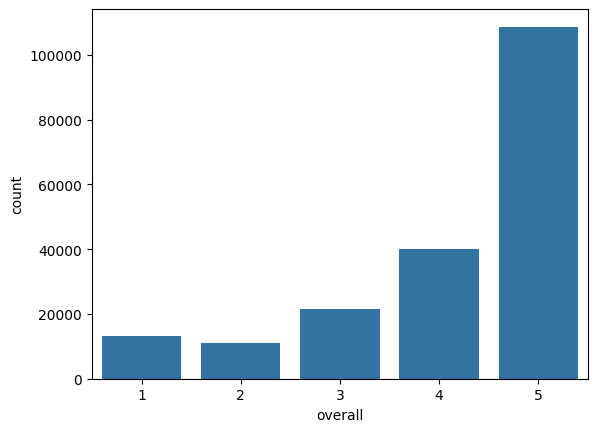

In [6]:
sns.countplot(data = review_data, x = 'overall')

## Keeping reviewText and overall columns

In [7]:
reviews = review_data['reviewText']
labels = review_data['overall']

## Train Test Split 

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.3, random_state =42 )

### OneHotEncoding

In [10]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_onehot = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1,1))

In [11]:
test_labels_onehot = one_hot_encoder.transform(y_test.to_numpy().reshape(-1,1))

In [12]:
train_labels_onehot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Baseline Model

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [14]:
baseline_model = make_pipeline(
    (TfidfVectorizer()),
    (MultinomialNB())
)

baseline_model.fit(X = X_train,
                   y = y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [15]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [16]:
def calculate_results(y_true, y_preds):
    '''
    Gives the accuracy, recall, precision and f1-score in a dictionary format

    Args:
         y_true: Actual values i.e label
         y_pred: Predictions given by the model
    
    Returns:
        A dictionary containing Accuracy, Recall, Precision, F1-score
    '''
    
    accuracy = accuracy_score(y_true, y_preds)
    precision, recall, f1_score , _ = precision_recall_fscore_support(y_true,y_preds, average= 'weighted')
    
    results = {'Accuracy':accuracy,
               'Recall':recall,
               'Precision':precision,
               'F1-score':f1_score}
    return results

In [17]:
baseline_model_predict = baseline_model.predict(X_test)
baseline_model_predict[:5]

array([5, 5, 5, 5, 5])

In [18]:
baselin_results = calculate_results(y_true = y_test, y_preds=baseline_model_predict)
baselin_results

/home/mayank/Mayank/PycharmProjects/TF_GPU/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.5595042172392511,
 'Recall': 0.5595042172392511,
 'Precision': 0.5021230020453383,
 'F1-score': 0.4025129432806949}

## Mixed Precision

In [19]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

2023-12-06 21:03:41.997715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660 Ti, compute capability 7.5


2023-12-06 21:03:42.445606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 21:03:42.445757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 21:03:42.446974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Tokenising and Embedding the Training data and OneHotEncoding Training Labels

### Tokenizing and Embedding

In [20]:
sequence_length = [len(sentence.split()) for sentence in X_train]
# sequence_length

In [21]:
output_sequence_length = int(np.percentile(sequence_length,95))
output_sequence_length

307

In [22]:
tokenizer = TextVectorization(max_tokens = None,
                            standardize = 'lower_and_strip_punctuation',
                            split = 'whitespace',
                            output_sequence_length = output_sequence_length
                            )

2023-12-06 21:03:43.195254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 21:03:43.195422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 21:03:43.195512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [23]:
tokenizer.adapt(X_train)

In [24]:
vocab = tokenizer.get_vocabulary()
print(f'Top five words{vocab[:5]} \nBottom five{vocab[-5:]}')

Top five words['', '[UNK]', 'the', 'i', 'and'] 
Bottom five['00005', '00002', '000000', '00000', '\x1d\x1dwhile']


In [25]:
embedding_layer = Embedding(input_dim = len(vocab),
                       output_dim = 512,
                       input_length = output_sequence_length,
                        mask_zero = True,
                       )

## Creating a Dataset

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_labels_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, test_labels_onehot))

In [27]:
train_dataset = train_dataset.batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Callbacks

In [28]:
def create_checkpoint(name):
    # filepath = 'checkpoints/{}.ckpt'.format(name)
    filepath = 'checkpoints/'+ name + '.ckpt'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath,
                                                    monitor = 'val_accuracy',
                                                    save_weights_only = True,
                                                    save_best_only = True,
                                                    save_freq = 'epoch',
                                                    verbose = 1
                                                   )
    return checkpoint

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 verbose =1,
                                                 patience = 3)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                verbose = 1,
                                                factor = 0.2,
                                                min_lr = 1e-7,
                                                patience = 1)

## Model

In [32]:
inputs = Input(shape=[1,], dtype = tf.string, name = 'input_layer')

x = tokenizer(inputs)
x = embedding_layer(x)

x = LSTM(64, return_sequences = True)(x)
x = LSTM(32)(x)
x = BatchNormalization()(x)

x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation = 'relu')(x)

outputs = Dense(5, activation = 'softmax', dtype = tf.float32)(x)

model = tf.keras.models.Model(inputs,outputs)

In [33]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

In [34]:
model_history = model.fit(train_dataset,
                         epochs = 100,
                         validation_data = test_dataset,
                         validation_steps = len(test_dataset),
                         callbacks = [create_checkpoint('model'),
                                     early_stopping,
                                     reduce_lr]
                         )

Epoch 1/100
4253/4254 [============================>.] - ETA: 0s - loss: 1.1062 - accuracy: 0.6158
Epoch 1: val_accuracy improved from -inf to 0.64057, saving model to checkpoints/model.ckpt
4254/4254 [==============================] - 288s 66ms/step - loss: 1.1062 - accuracy: 0.6158 - val_loss: 1.0480 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 2/100
4254/4254 [==============================] - ETA: 0s - loss: 0.9890 - accuracy: 0.6766
Epoch 2: val_accuracy improved from 0.64057 to 0.66629, saving model to checkpoints/model.ckpt
4254/4254 [==============================] - 249s 59ms/step - loss: 0.9890 - accuracy: 0.6766 - val_loss: 1.0053 - val_accuracy: 0.6663 - lr: 0.0010
Epoch 3/100
4253/4254 [============================>.] - ETA: 0s - loss: 0.8706 - accuracy: 0.7459
Epoch 3: val_accuracy did not improve from 0.66629

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4254/4254 [==============================] - 243s 57ms/step - loss: 0.8705 - accuracy: 0.

In [35]:
inputs = Input(shape=[1,], dtype = tf.string, name = 'input_layer')

x = tokenizer(inputs)
x = embedding_layer(x)

x = LSTM(64, return_sequences = True)(x)
x = LSTM(32)(x)
x = BatchNormalization()(x)

x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(16, activation = 'relu')(x)
x = BatchNormalization()(x)
outputs = Dense(5, activation = 'softmax',dtype = tf.float32)(x)

model2 = tf.keras.models.Model(inputs,outputs)

In [36]:
model2.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

In [37]:
model2_history = model2.fit(train_dataset,
                         epochs = 100,
                         validation_data = test_dataset,
                         validation_steps = len(test_dataset),
                         callbacks = [create_checkpoint('model2'),
                                     early_stopping,
                                     reduce_lr]
                         )

Epoch 1/100
4254/4254 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.7504
Epoch 1: val_accuracy improved from -inf to 0.62724, saving model to checkpoints/model2.ckpt
4254/4254 [==============================] - 308s 71ms/step - loss: 0.8795 - accuracy: 0.7504 - val_loss: 1.1322 - val_accuracy: 0.6272 - lr: 0.0010
Epoch 2/100
4254/4254 [==============================] - ETA: 0s - loss: 0.7546 - accuracy: 0.8169
Epoch 2: val_accuracy improved from 0.62724 to 0.64335, saving model to checkpoints/model2.ckpt
4254/4254 [==============================] - 254s 60ms/step - loss: 0.7546 - accuracy: 0.8169 - val_loss: 1.1277 - val_accuracy: 0.6434 - lr: 0.0010
Epoch 3/100
4254/4254 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.8517
Epoch 3: val_accuracy did not improve from 0.64335

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4254/4254 [==============================] - 246s 58ms/step - loss: 0.6894 - accuracy: 

## Using BERT

In [38]:
import tensorflow_hub as hub
import tensorflow_text

### Creating Dataset

In [39]:
train_dataset_bert = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_dataset_bert = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [40]:
train_dataset_bert = train_dataset_bert.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_bert  = test_dataset_bert.batch(32).prefetch(tf.data.AUTOTUNE)

### BERT

In [41]:
preprocessor_url = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
# encoder_url = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-256-a-4/versions/2"
encoder_url =     "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-128-a-2/versions/2"
preprocessor = hub.KerasLayer(preprocessor_url)

encoder = hub.KerasLayer(encoder_url, trainable=True)

In [42]:
inputs = tf.keras.Input(shape = (), dtype = tf.string)
x = preprocessor(inputs)
x = encoder(x)
x = tf.keras.layers.Dense(10, activation='relu')(x['pooled_output'])
outputs = tf.keras.layers.Dense(5, activation = 'softmax',dtype = tf.float32)(x)

bert = tf.keras.models.Model(inputs, outputs)

bert.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
             metrics = ['accuracy']
             )

bert.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [43]:
bert.fit(train_dataset,
         steps_per_epoch = int(len(train_dataset)),
         epochs = 100,
         validation_data=test_dataset,
         validation_steps =int(0.05*len(test_dataset)),
         callbacks = [create_checkpoint('bert_model'),
                                     early_stopping,
                                     reduce_lr]
            )

Epoch 1/100
4254/4254 [==============================] - ETA: 0s - loss: 1.0158 - accuracy: 0.5934
Epoch 1: val_accuracy improved from -inf to 0.62260, saving model to checkpoints/bert_model.ckpt
4254/4254 [==============================] - 474s 107ms/step - loss: 1.0158 - accuracy: 0.5934 - val_loss: 0.9277 - val_accuracy: 0.6226 - lr: 1.0000e-05
Epoch 2/100
4254/4254 [==============================] - ETA: 0s - loss: 0.9041 - accuracy: 0.6367
Epoch 2: val_accuracy improved from 0.62260 to 0.64320, saving model to checkpoints/bert_model.ckpt
4254/4254 [==============================] - 441s 104ms/step - loss: 0.9041 - accuracy: 0.6367 - val_loss: 0.8858 - val_accuracy: 0.6432 - lr: 1.0000e-05
Epoch 3/100
4254/4254 [==============================] - ETA: 0s - loss: 0.8652 - accuracy: 0.6514
Epoch 3: val_accuracy improved from 0.64320 to 0.65007, saving model to checkpoints/bert_model.ckpt
4254/4254 [==============================] - 445s 105ms/step - loss: 0.8652 - accuracy: 0.6514 - v

In [52]:
preprocessor_url = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
# encoder_url = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-256-a-4/versions/2"
encoder_url =     "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-128-a-2/versions/2"
preprocessor = hub.KerasLayer(preprocessor_url)

encoder = hub.KerasLayer(encoder_url, trainable=True)

In [53]:
inputs = tf.keras.Input(shape = (), dtype = tf.string)
x = preprocessor(inputs)
x = encoder(x)
x = tf.keras.layers.Dense(10, activation='relu')(x['pooled_output'])
outputs = tf.keras.layers.Dense(5, activation = 'softmax',dtype = tf.float32)(x)

bert2 = tf.keras.models.Model(inputs, outputs)

bert2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
             metrics = ['accuracy']
             )

bert2.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_6 (KerasLayer)  {'input_mask': (None, 128)   0         ['input_5[0][0]']             
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                            

In [54]:
bert2.fit(train_dataset,
         steps_per_epoch = int(0.1*len(train_dataset)),
         epochs = 100,
         validation_data=test_dataset,
         validation_steps =int(0.05*len(test_dataset)),
         callbacks = [create_checkpoint('bert2_model'),
                                     early_stopping,
                                     reduce_lr]
            )

Epoch 1/100
425/425 [==============================] - ETA: 0s - loss: 1.3767 - accuracy: 0.2234
Epoch 1: val_accuracy improved from -inf to 0.22390, saving model to checkpoints/bert2_model.ckpt
425/425 [==============================] - 98s 165ms/step - loss: 1.3767 - accuracy: 0.2234 - val_loss: 1.3257 - val_accuracy: 0.2239 - lr: 1.0000e-05
Epoch 2/100
214/425 [==============>...............] - ETA: 22s - loss: 1.2621 - accuracy: 0.3518

KeyboardInterrupt: 